In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt

from core.lettuce_model import lettuce_growth_model
from core.simulate import simulate_open_loop

In [4]:
import random
random.seed(40)

t_out, y_out, u_out = simulate_open_loop(lettuce_growth_model, sim_time=86400)

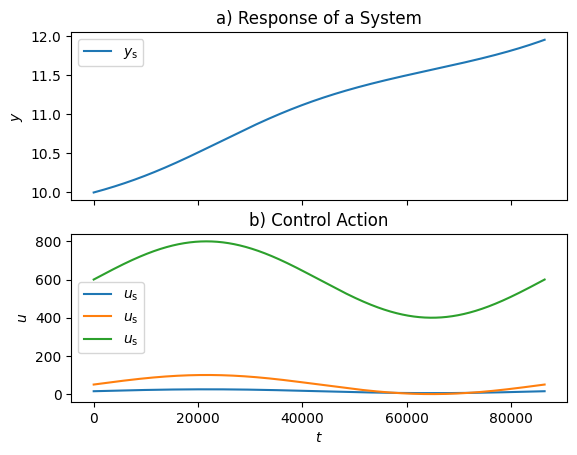

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
axs[0].plot(t_out, y_out[:,0], label=r'$y_{\mathrm{s}}$')
# axs[0].plot(t_out, y_ref[:,0], label=r'$y_{\mathrm{ref}}$', linestyle=":")
axs[0].set_ylabel('$y$')
axs[0].set_title('a) Response of a System')
axs[0].legend()

axs[1].plot(t_out, u_out, label=r'$u_{\mathrm{s}}$')
# color = {'color': axs[1]._get_lines.get_next_color()}
# axs[1].axhline(0, **color, linestyle=":")
# axs[1].axhline(400, **color, linestyle=":")
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$u$')
axs[1].set_title('b) Control Action')
axs[1].legend()

plt.show()